In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 4.2 MB/s 
     |████████████████████████████████| 1.8 MB 67.5 MB/s 
     |████████████████████████████████| 103 kB 36.8 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 3
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data.loc[data['set'] == 0, col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0438803
[100]	valid_0's binary_logloss: 0.0420873
[150]	valid_0's binary_logloss: 0.0412316
[200]	valid_0's binary_logloss: 0.0405748
[250]	valid_0's binary_logloss: 0.0401839
[300]	valid_0's binary_logloss: 0.0398424
[350]	valid_0's binary_logloss: 0.0395492
[400]	valid_0's binary_logloss: 0.0392523
[450]	valid_0's binary_logloss: 0.038973
[500]	valid_0's binary_logloss: 0.0387436
[550]	valid_0's binary_logloss: 0.0385114
[600]	valid_0's binary_logloss: 0.0382942
[650]	valid_0's binary_logloss: 0.0381129
[700]	valid_0's binary_logloss: 0.0379373
[750]	valid_0's binary_logloss: 0.0377873
[800]	valid_0's binary_logloss: 0.0376497
[850]	valid_0's binary_logloss: 0.0374958
[900]	valid_0's binary_logloss: 0.0373387
[950]	valid_0's binary_logloss: 0.0371999
[1000]	valid_0's binary_logloss: 0.0370628
[1050]	valid_0's binary_logloss: 0.0369221
[1100]	valid_0's binary_logloss: 0.0368293
[1150]	valid_0's binary_logloss: 0.0367126
[1200]	valid_0's binary_logloss:

In [ ]:
del train_data
gc.collect()

85

#Check Feature Importances

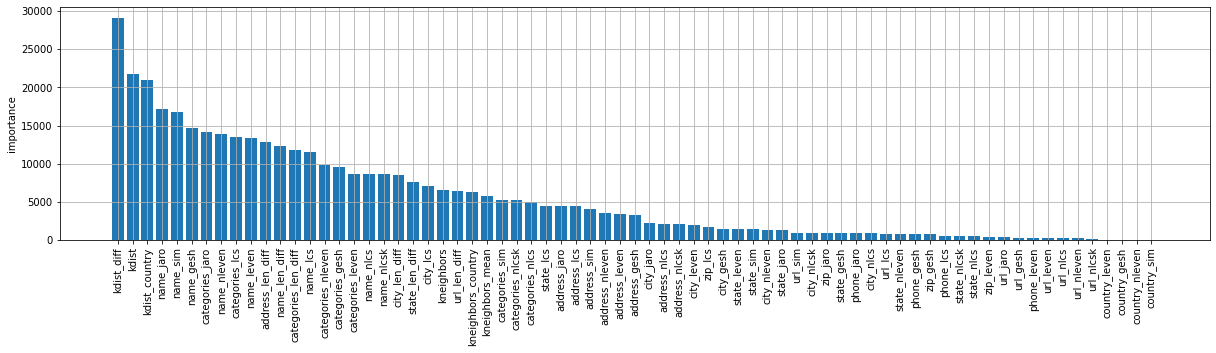

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 10.2 MB/s 
     |████████████████████████████████| 210 kB 67.3 MB/s 
     |████████████████████████████████| 78 kB 1.6 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
     |████████████████████████████████| 112 kB 82.2 MB/s 
     |████████████████████████████████| 146 kB 57.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=6dd24fd3ce25a389872ffee917d6227450be952bab0c4460be4efb634f29525f
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [28]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-25 13:19:17,231] A new study created in memory with name: no-name-5d30700b-be68-4645-9a79-d0013c86f2b2
[I 2022-05-25 13:19:48,523] Trial 0 finished with value: 0.8278262331165376 and parameters: {'threshold': 0.611777957381334}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827826


[I 2022-05-25 13:20:07,118] Trial 1 finished with value: 0.8241504949533126 and parameters: {'threshold': 0.419548302446756}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.824150


[I 2022-05-25 13:20:32,944] Trial 2 finished with value: 0.5428617222849067 and parameters: {'threshold': 0.003058231737245176}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.542862


[I 2022-05-25 13:20:51,032] Trial 3 finished with value: 0.8245391437468969 and parameters: {'threshold': 0.7731426339558528}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.824539


[I 2022-05-25 13:21:09,602] Trial 4 finished with value: 0.8213384686008236 and parameters: {'threshold': 0.8231023589286746}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.821338


[I 2022-05-25 13:21:27,714] Trial 5 finished with value: 0.8272815809614067 and parameters: {'threshold': 0.5361688943040945}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827282


[I 2022-05-25 13:21:47,939] Trial 6 finished with value: 0.7854280229933687 and parameters: {'threshold': 0.11020044841268717}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.785428


[I 2022-05-25 13:22:06,025] Trial 7 finished with value: 0.7824165491425263 and parameters: {'threshold': 0.9762217396768827}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.782417


[I 2022-05-25 13:22:25,055] Trial 8 finished with value: 0.8277157771342698 and parameters: {'threshold': 0.5873812474848517}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827716


[I 2022-05-25 13:22:45,168] Trial 9 finished with value: 0.8223579077673797 and parameters: {'threshold': 0.3784951704643136}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.822358


[I 2022-05-25 13:23:03,851] Trial 10 finished with value: 0.8127649816878648 and parameters: {'threshold': 0.2527005467526776}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.812765


[I 2022-05-25 13:23:22,863] Trial 11 finished with value: 0.8278059306828776 and parameters: {'threshold': 0.612888565511682}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827806


[I 2022-05-25 13:23:40,945] Trial 12 finished with value: 0.8277671088301892 and parameters: {'threshold': 0.6306370448716997}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827767


[I 2022-05-25 13:23:59,712] Trial 13 finished with value: 0.8263051543695513 and parameters: {'threshold': 0.7224169089082214}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826305


[I 2022-05-25 13:24:18,249] Trial 14 finished with value: 0.8087891695569928 and parameters: {'threshold': 0.9171188742197666}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.808789


[I 2022-05-25 13:24:36,471] Trial 15 finished with value: 0.824479072983617 and parameters: {'threshold': 0.4276555789222195}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.824479


[I 2022-05-25 13:24:55,354] Trial 16 finished with value: 0.8275721551393429 and parameters: {'threshold': 0.652822919911233}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827572


[I 2022-05-25 13:25:14,952] Trial 17 finished with value: 0.8166009168285536 and parameters: {'threshold': 0.2925195698038872}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.816601


[I 2022-05-25 13:25:33,232] Trial 18 finished with value: 0.826631456052266 and parameters: {'threshold': 0.5002848636548813}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826631


[I 2022-05-25 13:25:51,717] Trial 19 finished with value: 0.8180786445150858 and parameters: {'threshold': 0.8574549044662524}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.818079


[I 2022-05-25 13:26:09,740] Trial 20 finished with value: 0.826799742122101 and parameters: {'threshold': 0.7008888066458985}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826800


[I 2022-05-25 13:26:28,785] Trial 21 finished with value: 0.8278073310740973 and parameters: {'threshold': 0.6098410838167205}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827807


[I 2022-05-25 13:26:48,988] Trial 22 finished with value: 0.8273893746241573 and parameters: {'threshold': 0.5478553468384791}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827389


[I 2022-05-25 13:27:07,094] Trial 23 finished with value: 0.8276872909524505 and parameters: {'threshold': 0.6414918102483487}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827687


[I 2022-05-25 13:27:25,841] Trial 24 finished with value: 0.825797074546738 and parameters: {'threshold': 0.7404781922911694}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.825797


[I 2022-05-25 13:27:45,012] Trial 25 finished with value: 0.8251655337330096 and parameters: {'threshold': 0.44749326512250054}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.825166


[I 2022-05-25 13:28:03,664] Trial 26 finished with value: 0.8186427472152775 and parameters: {'threshold': 0.3186108358474664}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.818643


[I 2022-05-25 13:28:22,853] Trial 27 finished with value: 0.8262770001691581 and parameters: {'threshold': 0.4831767277048864}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826277


[I 2022-05-25 13:28:42,079] Trial 28 finished with value: 0.8277486918612028 and parameters: {'threshold': 0.5943837968373483}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827749


[I 2022-05-25 13:28:59,855] Trial 29 finished with value: 0.8223599494253054 and parameters: {'threshold': 0.8089434572309011}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.822360


[I 2022-05-25 13:29:19,172] Trial 30 finished with value: 0.8230558234197186 and parameters: {'threshold': 0.3931213851146817}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.823056


[I 2022-05-25 13:29:38,133] Trial 31 finished with value: 0.8276060219296822 and parameters: {'threshold': 0.6503581068369184}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827606


[I 2022-05-25 13:29:56,232] Trial 32 finished with value: 0.8277338628566999 and parameters: {'threshold': 0.5927660291957825}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827734


[I 2022-05-25 13:30:15,077] Trial 33 finished with value: 0.8273364955426461 and parameters: {'threshold': 0.6689526142865829}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827336


[I 2022-05-25 13:30:34,401] Trial 34 finished with value: 0.8247717300428482 and parameters: {'threshold': 0.7664530606546054}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.824772


[I 2022-05-25 13:30:53,613] Trial 35 finished with value: 0.827082704249276 and parameters: {'threshold': 0.524485983194799}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827083


[I 2022-05-25 13:31:11,799] Trial 36 finished with value: 0.8277213545084449 and parameters: {'threshold': 0.5888266165518581}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827721


[I 2022-05-25 13:31:30,276] Trial 37 finished with value: 0.8162875282858966 and parameters: {'threshold': 0.8731980060482477}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.816288


[I 2022-05-25 13:31:49,155] Trial 38 finished with value: 0.826676458355104 and parameters: {'threshold': 0.7054167560444291}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826676


[I 2022-05-25 13:32:08,183] Trial 39 finished with value: 0.8241418791966937 and parameters: {'threshold': 0.7812659499943858}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.824142


[I 2022-05-25 13:32:27,075] Trial 40 finished with value: 0.8055622758190185 and parameters: {'threshold': 0.1962649161358206}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.805562


[I 2022-05-25 13:32:46,064] Trial 41 finished with value: 0.8278239285673449 and parameters: {'threshold': 0.6055542331188233}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827824


[I 2022-05-25 13:33:05,023] Trial 42 finished with value: 0.8273489599708135 and parameters: {'threshold': 0.5440835672622298}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827349


[I 2022-05-25 13:33:24,233] Trial 43 finished with value: 0.8259335826545275 and parameters: {'threshold': 0.4698991549184325}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.825934


[I 2022-05-25 13:33:43,276] Trial 44 finished with value: 0.8277979203199375 and parameters: {'threshold': 0.6268931451159806}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827798


[I 2022-05-25 13:34:01,558] Trial 45 finished with value: 0.8275675365046746 and parameters: {'threshold': 0.5615771439211409}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827568


[I 2022-05-25 13:34:20,527] Trial 46 finished with value: 0.8271050145657703 and parameters: {'threshold': 0.6886310087881128}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827105


[I 2022-05-25 13:34:39,551] Trial 47 finished with value: 0.8277522204823169 and parameters: {'threshold': 0.6310496986709022}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827752


[I 2022-05-25 13:34:59,062] Trial 48 finished with value: 0.7716330471702822 and parameters: {'threshold': 0.07917269618332934}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.771633


[I 2022-05-25 13:35:18,124] Trial 49 finished with value: 0.8268410733552224 and parameters: {'threshold': 0.5095499983611611}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826841


[I 2022-05-25 13:35:37,147] Trial 50 finished with value: 0.8277898547603112 and parameters: {'threshold': 0.6181253916110172}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827790


[I 2022-05-25 13:35:55,393] Trial 51 finished with value: 0.8277967750066585 and parameters: {'threshold': 0.6150556000897438}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827797


[I 2022-05-25 13:36:14,348] Trial 52 finished with value: 0.8259812517673549 and parameters: {'threshold': 0.7335921630602529}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.825981


[I 2022-05-25 13:36:33,378] Trial 53 finished with value: 0.827567542393889 and parameters: {'threshold': 0.5610234950702517}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827568


[I 2022-05-25 13:36:52,257] Trial 54 finished with value: 0.8273058516514192 and parameters: {'threshold': 0.6713988629883941}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827306


[I 2022-05-25 13:37:11,312] Trial 55 finished with value: 0.8278017227049921 and parameters: {'threshold': 0.6136362116224722}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827802


[I 2022-05-25 13:37:29,515] Trial 56 finished with value: 0.8256590238090575 and parameters: {'threshold': 0.4591064223185388}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.825659


[I 2022-05-25 13:37:48,448] Trial 57 finished with value: 0.8276460263807156 and parameters: {'threshold': 0.5687593450099566}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827646


[I 2022-05-25 13:38:06,546] Trial 58 finished with value: 0.826877089922384 and parameters: {'threshold': 0.5150635718670781}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826877


[I 2022-05-25 13:38:25,187] Trial 59 finished with value: 0.8249913695335314 and parameters: {'threshold': 0.7605862113815965}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.824991


[I 2022-05-25 13:38:44,544] Trial 60 finished with value: 0.8232490013077631 and parameters: {'threshold': 0.3973118249531101}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.823249


[I 2022-05-25 13:39:02,511] Trial 61 finished with value: 0.8278077010487502 and parameters: {'threshold': 0.6216413951184594}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827808


[I 2022-05-25 13:39:21,216] Trial 62 finished with value: 0.8269754724120387 and parameters: {'threshold': 0.6934359249047497}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826975


[I 2022-05-25 13:39:40,221] Trial 63 finished with value: 0.8276685726914331 and parameters: {'threshold': 0.6431146533649621}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827669


[I 2022-05-25 13:39:58,362] Trial 64 finished with value: 0.8277194770437118 and parameters: {'threshold': 0.5894990067273911}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827719


[I 2022-05-25 13:40:17,340] Trial 65 finished with value: 0.8277989227843634 and parameters: {'threshold': 0.6151080099525031}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827799


[I 2022-05-25 13:40:35,138] Trial 66 finished with value: 0.8262170834157135 and parameters: {'threshold': 0.7248236163504463}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826217


[I 2022-05-25 13:40:53,744] Trial 67 finished with value: 0.8273322546399349 and parameters: {'threshold': 0.6689954539861841}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827332


[I 2022-05-25 13:41:12,846] Trial 68 finished with value: 0.8264122147123673 and parameters: {'threshold': 0.48914584799514044}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826412


[I 2022-05-25 13:41:31,095] Trial 69 finished with value: 0.8246018547980952 and parameters: {'threshold': 0.4316757072720311}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.824602


[I 2022-05-25 13:41:49,931] Trial 70 finished with value: 0.8277895782184591 and parameters: {'threshold': 0.5999245634736617}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827790


[I 2022-05-25 13:42:08,805] Trial 71 finished with value: 0.827794187202947 and parameters: {'threshold': 0.6204184335557708}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827794


[I 2022-05-25 13:42:27,660] Trial 72 finished with value: 0.8274454389735579 and parameters: {'threshold': 0.5538016829546372}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827445


[I 2022-05-25 13:42:46,540] Trial 73 finished with value: 0.8272406739766164 and parameters: {'threshold': 0.6774632520864754}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827241


[I 2022-05-25 13:43:04,602] Trial 74 finished with value: 0.8271465746905017 and parameters: {'threshold': 0.5274590082196676}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827147


[I 2022-05-25 13:43:23,342] Trial 75 finished with value: 0.8276242957107435 and parameters: {'threshold': 0.6475132110230603}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827624


[I 2022-05-25 13:43:41,969] Trial 76 finished with value: 0.8225999325683578 and parameters: {'threshold': 0.8055275247539236}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.822600


[I 2022-05-25 13:44:00,078] Trial 77 finished with value: 0.827734521055469 and parameters: {'threshold': 0.5852703448576548}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827735


[I 2022-05-25 13:44:18,901] Trial 78 finished with value: 0.8264472223217122 and parameters: {'threshold': 0.7185735922698698}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826447


[I 2022-05-25 13:44:37,900] Trial 79 finished with value: 0.8272770566640012 and parameters: {'threshold': 0.535994596349396}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827277


[I 2022-05-25 13:44:56,749] Trial 80 finished with value: 0.8278013581238072 and parameters: {'threshold': 0.6136087008205234}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827801


[I 2022-05-25 13:45:14,746] Trial 81 finished with value: 0.8277662775582986 and parameters: {'threshold': 0.6170639684190294}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827766


[I 2022-05-25 13:45:33,606] Trial 82 finished with value: 0.8276399920955985 and parameters: {'threshold': 0.5689856025172821}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827640


[I 2022-05-25 13:45:52,437] Trial 83 finished with value: 0.827576606344153 and parameters: {'threshold': 0.651677469459051}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827577


[I 2022-05-25 13:46:10,382] Trial 84 finished with value: 0.8268282650943558 and parameters: {'threshold': 0.6992704493913398}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826828


[I 2022-05-25 13:46:29,036] Trial 85 finished with value: 0.8278233057813891 and parameters: {'threshold': 0.6121038576349399}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827823


[I 2022-05-25 13:46:47,799] Trial 86 finished with value: 0.8278232578463596 and parameters: {'threshold': 0.6068977678711553}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827823


[I 2022-05-25 13:47:05,652] Trial 87 finished with value: 0.7635875220451728 and parameters: {'threshold': 0.9894724445180901}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.763588


[I 2022-05-25 13:47:23,552] Trial 88 finished with value: 0.8274192676207954 and parameters: {'threshold': 0.6638198133896039}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827419


[I 2022-05-25 13:47:42,561] Trial 89 finished with value: 0.8277580328496981 and parameters: {'threshold': 0.5772142260206837}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827758


[I 2022-05-25 13:48:01,693] Trial 90 finished with value: 0.8268227460661733 and parameters: {'threshold': 0.5086430156535643}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826823


[I 2022-05-25 13:48:19,525] Trial 91 finished with value: 0.8278120321295633 and parameters: {'threshold': 0.6085050558251732}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827812


[I 2022-05-25 13:48:38,195] Trial 92 finished with value: 0.8277908218704323 and parameters: {'threshold': 0.6021201010900606}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827791


[I 2022-05-25 13:48:56,935] Trial 93 finished with value: 0.8273248702559711 and parameters: {'threshold': 0.5449017483198721}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827325


[I 2022-05-25 13:49:15,451] Trial 94 finished with value: 0.8251055525250417 and parameters: {'threshold': 0.7570671240153419}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.825106


[I 2022-05-25 13:49:33,309] Trial 95 finished with value: 0.8277325970101487 and parameters: {'threshold': 0.6374404708578774}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827733


[I 2022-05-25 13:49:51,836] Trial 96 finished with value: 0.8271601252326766 and parameters: {'threshold': 0.6854924587268689}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827160


[I 2022-05-25 13:50:10,945] Trial 97 finished with value: 0.826250846614977 and parameters: {'threshold': 0.4816787569669515}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.826251


[I 2022-05-25 13:50:29,078] Trial 98 finished with value: 0.8277589109608459 and parameters: {'threshold': 0.5771810892985386}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827759


[I 2022-05-25 13:50:47,955] Trial 99 finished with value: 0.8277977224766685 and parameters: {'threshold': 0.600240406831317}. Best is trial 0 with value: 0.8278262331165376.


CV: 0.827798


In [29]:
threshold = study.best_params['threshold']
threshold

0.611777957381334

In [30]:
study.best_value

0.8278262331165376

In [31]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.827826


# 間違っているものの中身を見る

In [32]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [33]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,143494.000000,143494.000000,138930.000000,138930.000000,133803.000000,147552.000000,147552.0,147552.000000,147552.000000,147552.000000,...,147552.000000,147548.000000,147548.000000,147548.000000,147548.000000,147552.000000,147548.000000,147548.000000,147548.000000,1.475520e+05
mean,0.006303,6.161784,0.003463,6.186497,0.423828,6.454362,1.0,0.266799,0.413316,16.442034,...,0.998902,0.999010,0.001993,0.999020,1.998021,0.000027,0.000996,0.999010,0.999010,1.883187e-01
std,0.048268,5.235046,0.023467,5.242942,2.455521,5.301913,0.0,0.311945,0.250437,9.466006,...,0.033117,0.031007,0.062340,0.030959,0.062014,0.005207,0.031170,0.031007,0.031007,1.913699e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.136995e-13
25%,0.000435,2.000000,0.000328,2.000000,0.005979,2.000000,1.0,0.000000,0.210526,10.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.704377e-02
50%,0.001095,4.000000,0.000846,4.000000,0.056823,5.000000,1.0,0.000000,0.400000,15.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.137682e-01
75%,0.003013,10.000000,0.002319,10.000000,0.318002,10.000000,1.0,0.518425,0.594595,22.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,3.374259e-01
max,4.310371,19.000000,2.388985,19.000000,214.206825,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,6.117599e-01


In [34]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
3877035,E_cedc2bd6535ee7,E_781cc270b7f60c,1.528700e-03,6.0,P_ba2a17cb9fbc0d,5.708309e-04,1.0,1.678026,3.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.033660
9122462,E_0563b132b63caf,E_323bc3320a4f8c,1.029905e-03,16.0,P_ff67d8cadeb473,1.101567e-04,5.0,8.349458,10.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.128771
4233107,E_6f07529eab7d13,E_64eabdaefe0e00,1.959156e-03,7.0,P_1054f936471336,1.886560e-03,7.0,0.038481,7.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.016284
819054,E_701ab02d928b81,E_a749ba161e551a,1.704677e-03,1.0,P_f55be8cc55ff58,8.854170e-04,1.0,0.925282,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.068830
642814,E_20eebc0a2ae651,E_e9483353bd6ac9,6.881582e-03,1.0,P_bdd5875828705c,6.594852e-03,1.0,0.043478,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.549073
1113282,E_f4630e8cd2f066,E_91a0c2694400d5,3.573044e-03,1.0,P_d5b0152908e95e,3.473866e-03,1.0,0.028550,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.390085
5460515,E_96be7ccde6cb09,E_19ada2b8584c49,1.622778e-11,9.0,P_cd77000198e94c,1.619898e-11,9.0,0.001778,9.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.140780
837772,E_788740bc4d828d,E_67aa4d44562edc,2.230682e-04,1.0,P_2c1400ccf0a109,1.653460e-04,1.0,0.349100,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.312114
873521,E_888342cbde82fb,E_89f5e1e139ad74,8.407128e-05,1.0,P_bbd3c2796cb695,8.397501e-05,1.0,0.001146,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.089139
1598361,E_ce62ff5b56380f,E_d2115c46593d98,3.083381e-04,2.0,P_6edadd37c47c43,3.046225e-04,3.0,0.012197,2.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.346838


In [35]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
87903,E_13b3200d8056a9,阜杭豆漿 Fu Hang Dou Jiang,25.044283,121.524971,忠孝東路一段108號2F,台北市,台北市,100,TW,NaN,223922175,"Chinese Breakfast Places, Breakfast Spots",P_c858b49d006628,2,1.0
991965,E_ded5e34b5c6ccf,華山市場 阜杭豆漿,25.044513,121.524912,NaN,NaN,NaN,NaN,TW,NaN,NaN,NaN,P_c858b49d006628,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
580157,E_826a2902c8fcc1,ข้าวต้มตันหยง,13.863155,100.500133,NaN,บางกระสอ,จ.นนทบุรี,11000,TH,NaN,NaN,Soup Places,P_26a5eda40b64f5,3,1.0
1122014,E_fc3969ddc661f3,ตันหยงข้าวต้มปลา,13.863343,100.500225,Rattanathibet Rd,Mueang Nonthaburi,Nonthaburi,11000,TH,NaN,NaN,Asian Restaurants,P_26a5eda40b64f5,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
591438,E_84f18da34a0029,Bay Walk Pluit,-6.108025,106.779911,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_b9ffbac7811385,4,1.0
876132,E_c4cde54f31eef5,Management Office - Baywalk Mall,-6.108938,106.778794,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_b9ffbac7811385,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
320959,E_48279618acfe3d,투썸플레이스 동서울터미널,37.534748,127.094170,NaN,NaN,NaN,NaN,KR,NaN,NaN,Coffee Shops,P_cf895eada2a314,1,1.0
449530,E_650390502aac54,A TWOSOME PLACE,37.535339,127.094203,광진구 강변역로 50,광진구,서울특별시,05116,KR,http://twosome.co.kr,+8224569454,Coffee Shops,P_cf895eada2a314,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
347130,E_4e02f866a6ba32,Ginno Taki,59.944018,30.359709,NaN,Санкт-Петербург,NaN,NaN,RU,NaN,NaN,Asian Restaurants,P_53a32a1e9fa620,1,1.0
804227,E_b496d4b3826064,Гин-но Таки,59.944988,30.358854,"просп. Чернышевского, 17",Санкт-Петербург,Санкт-Петербург,191123,RU,http://www.ginnotaki.ru,8122720958,Japanese Restaurants,P_53a32a1e9fa620,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
646123,E_913961334fe030,1-й учебный корпус на Ломоносовском проспекте,55.700502,37.520279,"Ломоносовский проспект, д. 27, корп.4",Москва,NaN,NaN,RU,NaN,NaN,Universities,P_134489478eeca2,4,1.0
653549,E_92ddd2e28fd1a4,Студуголок,55.700822,37.520164,NaN,NaN,NaN,NaN,RU,NaN,NaN,"College Rec Centers, Cultural Centers",P_134489478eeca2,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
192514,E_2b315ed66a9502,Вареники,55.727133,37.606764,МГГУ,Москва,Москва,NaN,RU,NaN,NaN,Dumpling Restaurants,P_6e85b59e1a3a03,2,1.0
901555,E_ca81c20c18df5d,музей мицинатов,55.725826,37.609955,NaN,NaN,NaN,NaN,RU,NaN,NaN,Museums,P_6e85b59e1a3a03,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
204242,E_2dd486b82794d8,gedung tower universitas mercubuana (T.303),-6.210079,106.738544,Jl. Meruya selatan,NaN,NaN,NaN,ID,NaN,NaN,College Classrooms,P_aa08084e1c1d71,4,1.0
496943,E_6fb29efd3b6f00,Koridor B Universitas Mercu Buana,-6.210513,106.738435,Jl. Meruya Selatan,Jakarta Barat,DKI Jakarta,NaN,ID,NaN,NaN,Community Colleges,P_aa08084e1c1d71,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
833829,E_bb40aabbd54f9b,спортивный зал 1347,55.657913,37.406165,NaN,NaN,NaN,NaN,RU,NaN,NaN,Ballrooms,P_59527eb5c8219a,2,1.0
1046052,E_eb0ce99fe447ae,Школа № 1347 (главное здание),55.657177,37.406004,"ул. Главмосстроя, 28",Москва,Москва,NaN,RU,NaN,NaN,Schools,P_59527eb5c8219a,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
213548,E_2ff2d7320f3788,West Side Auto Sales And Service Center,43.063307,-85.690935,5511 Alpine Ave NW,Comstock Park,MI,49321,US,http://www.westsideautosalesservicecenter.com,(616) 288-3206,"Used Auto Dealerships, Automotive Shops",P_347d738f928e5c,1,1.0
770873,E_ad26339303f5f4,westside auto,43.056058,-85.690455,NaN,Alpine,MI,NaN,US,NaN,NaN,Automotive Shops,P_347d738f928e5c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
457296,E_66c1ea577122d7,Deskomps,19.531474,-99.027288,Multiplaza Aragón,Ecatepec,NaN,NaN,MX,NaN,NaN,Electronics Stores,P_f5c65d4593e333,1,1.0
753031,E_a9248009548578,Dezkomp,19.530597,-99.027261,NaN,Ecatepec,NaN,NaN,MX,NaN,NaN,Electronics Stores,P_f5c65d4593e333,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
820919,E_b858e9d915bf45,Gulf University For Science and Technology (West),29.274739,48.052944,NaN,Mishrif,Kuwait,NaN,KW,NaN,NaN,Community Colleges,P_64fb6433d71d51,4,1.0
952675,E_d600cc3bd7911d,Gulf University for Science & Technology,29.273405,48.052648,Mubarak Al-Abdullah Area/West Mishref - Kuwait,Kuwait,Kuwait,32093,KW,http://www.gust.edu.kw,96525307000,"Universities, General Colleges & Universities,...",P_64fb6433d71d51,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
209042,E_2eea189ae35f0d,Editing Promo Lantai 2,-6.240913,106.829301,NaN,NaN,NaN,NaN,ID,NaN,NaN,Coworking Spaces,P_745299120115a1,4,1.0
923550,E_cf75bc2374d242,Tangga Darurat Lantai 5,-6.241145,106.829839,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_745299120115a1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
814069,E_b6d11ef5fa7088,Trans 7 5th floor (PT. Televisi Transformasi I...,-6.241248,106.830043,NaN,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_745299120115a1,4,1.0
1021436,E_e57c505d487359,subtitling lt.2 TransTV,-6.241107,106.829918,NaN,NaN,NaN,NaN,ID,NaN,NaN,Libraries,P_745299120115a1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
326592,E_496c299611b390,Yatağan Anadolu Meslek Lisesi,37.337320,28.134895,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_d65284692ca14c,4,1.0
522623,E_75733e758f132f,Metem 215. Koguş,37.336992,28.131626,NaN,NaN,NaN,NaN,TR,NaN,NaN,High Schools,P_d65284692ca14c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
37712,E_087544a9aae1b7,"Marshal Post 2B, SIC",2.761057,101.733951,NaN,NaN,NaN,NaN,MY,NaN,NaN,Racetracks,P_140231c0dfd7af,4,1.0
409539,E_5c096c12cce05d,2013 Malaysian F1 Grand Prix,2.761192,101.742594,NaN,NaN,NaN,NaN,MY,NaN,NaN,Racetracks,P_140231c0dfd7af,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
488311,E_6dc3b56faa2f13,KB국민은행,37.552718,126.918687,마포구 양화로 78,서울특별시,NaN,NaN,KR,NaN,23321475,Banks,P_4d0ee3def9e9de,1,1.0
746803,E_a7c9ccdaea5715,KB국민은행,37.551606,126.916679,마포구 서교동 396-166,Seoul,Seoul,NaN,KR,NaN,NaN,Banks,P_4d0ee3def9e9de,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
357206,E_504a606f190d4c,#1315 Fc Place,13.600810,100.845316,NaN,NaN,NaN,NaN,TH,NaN,NaN,Residential Buildings (Apartments / Condos),P_538d48ece2d151,4,1.0
970646,E_da0841b5a8f467,FC PLACE 2408,13.596181,100.851715,NaN,NaN,NaN,NaN,TH,NaN,NaN,Residential Buildings (Apartments / Condos),P_538d48ece2d151,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
502108,E_70e805ca73d3ab,다다의작은공간,33.441440,126.377814,애월읍 광상로 528-1,제주시,제주도,63037,KR,NaN,+821089699132,"French Restaurants, Restaurants, Modern Europe...",P_2cb60596069952,2,1.0
686938,E_9a4737d98035e8,다소곳,33.441436,126.377839,제주시 애월읍 소길리 573-9,제주시,제주도,63730,KR,NaN,NaN,Restaurants,P_2cb60596069952,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
463104,E_680b07f8460a55,"""Метро \""Проспект Большевиков\""""",59.829901,30.373599,NaN,NaN,NaN,NaN,RU,NaN,NaN,Metro Stations,P_ec0e7638dcedc2,4,1.0
798618,E_b35ce37ed878cd,Метрокупчино,59.829814,30.375389,Купчино,NaN,NaN,NaN,RU,NaN,NaN,Housing Developments,P_ec0e7638dcedc2,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
78870,E_11a03a7b6811b5,Perpustakaan Universitas Indonesia - Crystal o...,-6.365416,106.829810,Universitas Indonesia,Depok,Jawa Barat,16424,ID,http://www.lib.ui.ac.id,217270159,"College Libraries, Libraries, College Bookstores",P_7568b70156fe67,4,1.0
462321,E_67dcf3d339591c,Perpustakaan UI,-6.365664,106.827831,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_7568b70156fe67,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
209461,E_2f026e806270a6,Cluna,35.709267,51.406630,Valiasr street,Tehran,NaN,NaN,IR,NaN,NaN,Snack Places,P_6e6ba48752ce3e,2,1.0
496936,E_6fb25122df5ed5,Cluna,35.711651,51.406157,Vali Asr Sq.,Tehran,Tehran,NaN,IR,http://cluna.ir,+982188946645,"Snack Places, Coffee Shops",P_6e6ba48752ce3e,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
515055,E_73c6d2e657e3b5,MC Downald's,-8.637177,115.222954,NaN,NaN,NaN,NaN,ID,NaN,NaN,Diners,P_c730ea386b8093,4,1.0
1092112,E_f5714ef798b1d8,Mc donald's jl gatsu tengah (jl nagka utara 1),-8.642403,115.223497,NaN,NaN,NaN,NaN,ID,NaN,NaN,Burger Joints,P_c730ea386b8093,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
380273,E_556f845593fde8,Koong Woh Tong (恭和堂),3.090744,101.742604,Cheras Leisure Mall,Kuala Lumpur,WP Kuala Lumpur,56100,MY,NaN,NaN,"Tea Rooms, Snack Places",P_bcfbb5752bc2bf,2,1.0
460097,E_6760a6a44140d3,kong woh Tong,3.091519,101.742661,NaN,NaN,NaN,NaN,MY,NaN,NaN,Tea Rooms,P_bcfbb5752bc2bf,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
411632,E_5c80b7132f080f,XI Bahasa SMA Stella Duce 1 Yogyakarta,-7.784142,110.372054,Jl. Sabirin no 1-3,Yogyakarta,DIY,NaN,ID,NaN,NaN,College Classrooms,P_10c6663dd84b76,4,1.0
1070409,E_f0908ba5393ffa,"Biology Laboratory, Stella Duce 1 SHS",-7.784090,110.371610,Kotabaru,Yogyakarta,Indonesia,NaN,ID,NaN,NaN,College Labs,P_10c6663dd84b76,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
375418,E_54597dd16b49d1,Kyk 416 Room,38.311200,31.167429,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_446015b3a94560,4,1.0
1043743,E_ea864a2e07dbe4,Kyk Kız Yurdu,38.311533,31.167311,NaN,Yalvaç,Yalvaç,NaN,TR,NaN,NaN,College Residence Halls,P_446015b3a94560,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
249165,E_37ee0f9a481610,Dinlenme Modu,38.822959,37.922063,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_b95bc2ba795f5c,4,1.0
1120527,E_fbe77c311f05a5,Olmazsa Olmazzz😋,38.822975,37.922021,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_b95bc2ba795f5c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
616593,E_8aa0dbdf3cb54a,Сентіменто,50.616837,26.264062,"ул. Княгини Ольги, 4",Ровно,Ровенская обл.,33014,UA,NaN,362636949,"Pizza Places, Bars",P_8d75f7294dcc38,1,1.0
1110525,E_f99d7589635e48,Тарантелла,50.616842,26.264437,NaN,NaN,NaN,NaN,UA,NaN,NaN,Pizza Places,P_8d75f7294dcc38,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
397248,E_594331deff4250,"首页 - 怎么在微信榆林原版lv哪里卖,什么价位清",38.413248,-95.925751,gb日高仿▊选款薇★呺1143⒏⒏б⒏▊奢侈品包包原版a货精仿法国▊选款薇★呺1143⒏⒏б...,首页 -,KS,NaN,US,NaN,NaN,Ethiopian Restaurants,P_bb53ce072cad10,4,1.0
1063937,E_ef1d541a9820c6,"首页 - 怎么在微信原版lv衣服老花系列,什么价位幽",38.413248,-95.925751,nn也高仿▊选款薇★呺1143⒏⒏б⒏▊奢侈品包包原版a货精仿法国▊选款薇★呺1143⒏⒏б...,首页 -,KS,NaN,US,NaN,NaN,Ethiopian Restaurants,P_bb53ce072cad10,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
26106,E_05d8d5ae2043dd,Зелёные холмы 🍃🌳,55.682361,37.669733,Гимназия 1527,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_e5cbe4606de46c,4,1.0
812444,E_b673a995b121bf,Дежурство в 1527,55.682538,37.668445,"Пр-т Андропова, д. 17/5",NaN,NaN,NaN,RU,NaN,NaN,Schools,P_e5cbe4606de46c,4,1.0


labelが0なのに1と予測しているもの

In [36]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,55209.000000,55209.000000,53417.000000,53417.000000,51821.000000,56348.000000,56348.0,56348.000000,56341.000000,56341.000000,...,56348.000000,56345.000000,56345.000000,56345.000000,56345.000000,56348.0,56345.000000,56345.000000,56345.000000,56348.000000
mean,0.009117,4.701534,0.003505,4.677088,0.411580,4.960788,0.0,0.575297,0.598906,12.370973,...,0.997906,0.998128,0.003958,0.998048,1.996255,0.0,0.001979,0.998128,0.998128,0.833094
std,0.115008,4.867208,0.014761,4.848369,1.573221,4.996062,0.0,0.351128,0.250456,9.370720,...,0.045714,0.042140,0.087979,0.043738,0.084279,0.0,0.043989,0.042140,0.042140,0.121365
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.611779
25%,0.000303,1.000000,0.000230,1.000000,0.007480,1.000000,0.0,0.325500,0.432432,5.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.725162
50%,0.000887,2.000000,0.000661,2.000000,0.066908,3.000000,0.0,0.642260,0.615385,11.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.844813
75%,0.003115,7.000000,0.002299,7.000000,0.318399,7.500000,0.0,0.869517,0.787879,17.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.947871
max,11.519732,19.000000,0.720658,19.000000,85.764924,19.000000,0.0,1.000000,1.000000,58.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [37]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
785331,E_61040c86c80874,E_4ac1bf74d9245b,0.000077,1.0,P_499883be33d5d0,0.000059,1.0,0.295149,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.983515
975457,E_b63d3b57467e51,E_69a96465a8dc3e,0.017541,1.0,P_e065dc5696761a,0.009600,8.0,0.827111,4.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.886545
1434285,E_84aa258924953a,E_67d30926c0ccc5,0.000374,2.0,P_f370092759b06e,0.000317,2.0,0.178121,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.700146
2489284,E_5f12f38c12b5c8,E_7558664ad6f647,0.203907,4.0,P_5614274e32f509,0.021337,8.0,8.556459,6.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.996604
1329081,E_5566710aaf0ec4,E_1bd9e2a90bf2df,0.019051,2.0,P_5ae7c3ef2ce0ff,0.007597,2.0,1.507811,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.983208
5736232,E_12e83385fb8e9f,E_846fb107028db8,0.000733,10.0,NaN,NaN,NaN,NaN,10.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.860349
1701073,E_fcc33571774a43,E_78d0f447c896f4,0.000465,2.0,P_b15a045dd3745f,0.000464,2.0,0.002773,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.691422
606260,E_1088e940bc8bef,E_77519df41e0337,0.000437,1.0,P_2e39ba4770ee81,0.000436,1.0,0.002318,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.747652
657319,E_27659bfd744336,E_c02d51cf7e4935,0.000223,1.0,P_ab92d9d1e14cf5,0.000220,1.0,0.015996,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.971003
845361,E_7bf7d605d2d35d,E_aa3609d8eb025a,0.000809,1.0,P_d10c3d49a6ba66,0.000589,1.0,0.373615,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.723754


In [38]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
64698,E_0e79e15bcdf0e3,Burleson Seventh Day Adventist,32.531002,-97.309268,NaN,Burleson,TX,76028,US,NaN,NaN,NaN,P_6a1b358ef2bbdb,1,1.0
155298,E_22c8f1d5b0866a,Burleson Monuments,32.542377,-97.317621,NaN,Burleson,TX,NaN,US,NaN,NaN,NaN,P_5f11dac744e070,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
656308,E_937c5fc02a01b9,Vika's Sweet Home),55.614407,37.738415,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_2d7c14bc257e5b,0,1.0
898330,E_c9ca8759b2607f,💜Vika's Home💜,55.616227,37.736749,Ореховый бульвар д37,Москва,NaN,115573,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_73e42211cc5c46,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
38665,E_08acdfd9f689a7,Ward 7B Hospital Selayang,3.243479,101.646276,NaN,NaN,NaN,NaN,MY,NaN,NaN,Hospitals,P_20251253b92278,0,1.0
1067470,E_efea00b1f8f86a,Hospital Selayang,3.242339,101.646615,Lebuhraya Selayang-Kepong,Batu Caves,Selangor,68100,MY,http://www.selayanghospital.gov.my,361367788,Hospitals,P_48e9fcbace22dc,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
260064,E_3a649fe79acd0b,İhsangazi Emniyet Müdürlüğü,41.201733,33.556450,NaN,NaN,NaN,NaN,TR,NaN,NaN,Police Stations,P_67feed7119117c,1,1.0
320263,E_47fd237ae7d452,İhsangazi Orman İşletme Müdürlüğü,41.202309,33.552372,NaN,İhsangazi,Kastamonu,NaN,TR,NaN,NaN,Buildings,P_f5fe65ae6fcab0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
204462,E_2de288ab6c5361,ユニクロ 京都ヨドバシ店,34.988076,135.758686,Kyoto-Yodobashi,京都市,京都府,600-8216,JP,NaN,NaN,Clothing Stores,P_1248079b54ef23,1,1.0
950983,E_d59ee0c72b3ad3,京都ヨドバシ,34.988209,135.758997,NaN,京都市下京区,京都府,600-8216,JP,NaN,NaN,NaN,P_8520fbdcccf7d3,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
927280,E_d04a8f49b16b9c,Pelin Hotel,36.665575,29.110971,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hotels,P_24891e53bf350e,1,1.0
1127897,E_fd886a76f5b6e7,Ceren Hotel,36.665641,29.106768,Fethiye Çalış Beach Fethiye,Muğla,Türkiye,NaN,TR,http://fbf.bz/b/a2j,+902526221130,"Hotels, Resorts",P_0aad6efb5786b4,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
563039,E_7e8841c5add7d5,Ahmet Ziyaüddin Gümüşhanevi Öğrenci Yurdu,40.440585,39.498583,"Bağlarbaşı Mah. Şahbenderler Semti, Küme Evler...",Gümüşhane,Gümüşhane,29010,TR,http://yurtkur.gsb.gov.tr,+904562337022,College Residence Halls,P_e95f944b2b33b8,1,1.0
900395,E_ca4151412ddedb,Zeynep Ana Kız Öğrenci Yurdu,40.437775,39.505878,NaN,Gümüşhane,Gümüşhane,29010,TR,NaN,NaN,College Residence Halls,P_13f256d5147945,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
109186,E_18789230e96fb0,Hailun Rd. Metro Stn. (海伦路地铁站),31.260841,121.484538,"Siping Rd, Hailun Rd | 四平路, 海伦路",Hongkou,上海,NaN,CN,http://service.shmetro.com/en/yxxlt/index.htm,+862164370000,Metro Stations,P_a4a3383d554f8f,1,1.0
525943,E_762f41d1c9f097,Dongbao Metro Station,31.260895,121.475937,NaN,NaN,NaN,NaN,CN,NaN,NaN,Metro Stations,P_a798bbb393ae2e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
7165,E_01a1c956159538,Mc Donald's,-23.650587,-46.545375,Av dos Estados,Sao Caetano do Sul,NaN,NaN,BR,NaN,NaN,Diners,P_768d4503a55292,0,1.0
81339,E_123059e83864f3,McDonald's,-23.652769,-46.533914,"Av. D. Pedro II, 339",Santo André,SP,09080-110,BR,http://www.mcdonalds.com.br,1144322012,Fast Food Restaurants,P_787cbd4778cff3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
616500,E_8a9b4b19755ced,MovieTown,10.659353,-61.532808,None,Invaders Bay,St. George,NaN,TT,NaN,NaN,"Movie Theaters, Multiplexes",P_76e481dff1289a,0,1.0
802071,E_b41dd6b1f4adf9,MovieTowne,10.658533,-61.532568,"Lot D, MovieTowne Boulevard",Port of Spain,St. George,NaN,TT,http://www.movietowne.com,8686278277,Multiplexes,P_5e858930986e26,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
611546,E_897e26c26de97d,Taman Alfa Indah,-6.221228,106.756201,Taman Alfa Indah Block J 1 No 53,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_d6b66c06cc8400,0,1.0
1001789,E_e10a79931aa111,Taman Alfa Indah Blok A6/4,-6.219122,106.750060,NaN,Jakarta Barat,NaN,11640,ID,NaN,NaN,NaN,P_22053d4a592eef,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
64862,E_0e83957fc0ce82,Diani Reef Beach Resort & Spa,-4.278981,39.593856,NaN,NaN,NaN,NaN,KE,NaN,NaN,Resorts,P_d0559747e764ce,0,1.0
846283,E_be0e51c719e963,Sake Restuarant; Diani Reef Beach Resort and Spa,-4.279127,39.593906,NaN,NaN,NaN,NaN,KE,NaN,NaN,Resorts,P_00c38f26bcff69,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
695277,E_9c2b6869a9f104,CGH Ward 27,1.340021,103.949304,Changi General Hospital,Singapore,NaN,NaN,SG,NaN,NaN,Hospitals,P_7cb19c7333384b,0,1.0
796146,E_b2d059aee03ad9,CGH Ward 23 (MICU),1.340227,103.949248,Changi General Hospital,Singapore,NaN,NaN,SG,NaN,NaN,Hospitals,P_3948c5ff1b1bff,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
221829,E_31d28a31d63b4f,七十七銀行 扇町支店,38.267689,140.946534,扇町2-2-22,仙台市宮城野区,宮城県,983-0034,JP,NaN,222317511,Banks,P_3c52555cf0d09e,1,1.0
996065,E_dfc54cb1b1ca6b,七十七銀行 卸町支店,38.267689,140.946534,宮城野区萩野町3-9-1,仙台市,宮城県,983-0043,JP,NaN,+81222323277,Banks,P_2747d9f7698e54,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
385038,E_568100d9c0663c,C-Wing :: Ramapo College,41.081258,-74.174310,505 Ramapo Valley Rd,Mahwah,NJ,07430,US,http://ramapo.edu,NaN,College Academic Buildings,P_3d1d6122294a7e,0,1.0
1025509,E_e66d56af074fb1,D-Wing :: Ramapo College,41.081384,-74.174491,505 Ramapo Valley Rd,Mahwah,NJ,07430,US,http://t.co/ku1y9bRUg4,NaN,College Academic Buildings,P_3a8a6b08a09a48,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
738663,E_a5f1a677f9f769,Gedung B Ruang Hukum Perburuhan Fakultas Hukum...,3.556750,98.661619,NaN,NaN,NaN,NaN,ID,NaN,NaN,Law Schools,P_5b2efbb0351e4d,0,1.0
1021886,E_e598bb16f23074,Gedung D Lantai 2 Ruang 205 Fakultas Hukum USU,3.557529,98.659157,Jalan universitas,Medan,North Sumatra,NaN,ID,NaN,NaN,NaN,P_ecf0ebe9f7742d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
386241,E_56c694ec61903b,Marmara park emo,41.009831,28.65986,NaN,NaN,NaN,NaN,TR,NaN,NaN,Optical Shops,P_7d59c3f48ce2d0,0,1.0
425272,E_5f8e5306d3be5c,Marmarapark,41.009846,28.66009,NaN,NaN,NaN,NaN,TR,NaN,NaN,Shopping Malls,P_cdab22fcc60ae6,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
77191,E_11444b6ea86b0a,Valiler Sitesi,40.826052,29.315838,İstasyon Mah. Vatan Cad.,Tuzla,Istanbul,NaN,TR,NaN,NaN,Housing Developments,P_4b588b2a7b6cae,2,1.0
582147,E_82d9ef32276e16,Güldeniz Sitesi,40.821718,29.319405,NaN,İstanbul,NaN,NaN,TR,NaN,NaN,Housing Developments,P_13521dcce17681,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
805490,E_b4e1744acb83f8,Library @True Tower,13.762299,100.568062,NaN,NaN,NaN,NaN,TH,NaN,NaN,Libraries,P_0528eac4559d50,0,1.0
916864,E_cdf5056135f42d,"""ร้านก๋วยเตี๋ยวเนื้อหอม\""มุสซี่\""""",13.762017,100.567893,รัชดา ซอย4,Bangkok,NaN,NaN,TH,NaN,NaN,Restaurants,P_3bc79ddaeae38d,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
472346,E_6a276e82d04e42,Catalunya Caixa,41.433240,2.148300,NaN,NaN,NaN,NaN,ES,NaN,NaN,Banks,P_ce589e327b8557,0,1.0
853835,E_bfc32b6909c9c8,La Caixa,41.433564,2.148538,"Berruguete, 74",Barcelona,Cataluña,NaN,ES,NaN,NaN,Banks,P_79ea1f2458e090,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
186,E_000c1e53567646,Esbaş,38.336512,27.133751,NaN,NaN,NaN,NaN,TR,NaN,NaN,Coworking Spaces,P_9ef6227fc7603a,4,1.0
996284,E_dfd114f0e677f3,Birleşik Gümrük Müşavirliği ESBAŞ,38.337319,27.132315,NaN,NaN,NaN,NaN,TR,NaN,NaN,Coworking Spaces,P_df0e6083b5910a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
231493,E_33f6011aa115c8,Alun-alun Jombang,-7.557245,112.229969,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_c138b9cb766c48,4,1.0
424281,E_5f524991c62675,Jombang City,-7.556090,112.225306,Jombang,Jombang,Jawa Timur,NaN,ID,NaN,NaN,NaN,P_1c69c6a7d79f44,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
377820,E_54e24e5bc7b7b5,Lab Statistik Lingkungan FTSP UPN,-7.333900,112.787200,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_80e8bcca48220d,0,1.0
381200,E_55a6a032f70fcb,Lab teknik lingkungan FTSP UPN,-7.333899,112.787197,Gunung Anyar,Surabaya,East Java,NaN,ID,NaN,NaN,NaN,P_3460b342d79e41,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
150150,E_21a99c6d7667ce,Room 8.3.A Budi Luhur University,-6.23624,106.747101,Jalan Ciledug Raya,Jakarta,NaN,NaN,ID,NaN,NaN,College Classrooms,P_f6b2353460a7d9,0,1.0
405291,E_5b12e9a7b0c7fe,Room 3.2.4 Budi Luhur University,-6.23635,106.747200,"Jalan Ciledug Raya, Petukangan Utara",DKI Jakarta,Indonesia,12260,ID,NaN,NaN,College Classrooms,P_2d9097c2ac14d7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
597199,E_8638a76a5cfc35,ก๋วยเตี๋ยวเรือวังหลัง,13.754828,100.486218,Trok Wang Lang,Bangkok Noi,กรุงเทพมหานคร,10700,TH,NaN,NaN,Noodle Houses,P_e1df5702e422a7,1,1.0
718025,E_a14a74e4a76dbf,ก๋วยเตี๋ยวแคะ ไปรษณีย์กลาง(วังหลัง),13.755360,100.485691,NaN,NaN,NaN,NaN,TH,NaN,NaN,"Noodle Houses, Delis / Bodegas, Asian Restaurants",P_752955fc5b3cd8,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
374898,E_543b9030356bbf,Jobar - Bangalos dos Gameleiros,-8.699969,-35.085076,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_3a559361b7bae9,0,1.0
530457,E_7734eb18a3b515,Pousada Praia Dos Carneiros,-8.699913,-35.085275,"Via Litorânea dos Carneiros,",Tamandaré,Pernambuco,5558000,BR,NaN,8130371324,"Bed & Breakfasts, Seafood Restaurants",P_fccf1dec4fb161,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
19672,E_046a78ea50c95f,ROCKIN-ROKIN,52.370322,4.892146,NaN,Amsterdam,NH,NaN,NL,NaN,NaN,NaN,P_d6c863124f4dd0,0,1.0
545687,E_7aa09b62c8dd82,Rokin Fontein,52.372051,4.892999,NaN,Amsterdam,Noord-Holland,1012 KR,NL,NaN,NaN,Fountains,P_57a9298f8ac513,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
476438,E_6b14028643e332,kingwood library,39.47158,-79.689737,NaN,Kingwood,WV,26537,US,NaN,NaN,Libraries,P_af3c96f9dd4dee,0,1.0
1004920,E_e1bcc6ec120bd9,Kingwood plaza,39.47168,-79.690094,NaN,Kingwood,WV,26537,US,NaN,NaN,Buildings,P_9cf1af53708a91,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
94037,E_1514b43e92c00f,parking,43.652898,-79.376773,SW corner,Toronto,ON,NaN,CA,NaN,NaN,Parking,P_255e20892908ca,0,1.0
460633,E_677fff98b7bd99,Public Parking,43.654438,-79.376423,Church,Toronto,NaN,NaN,CA,NaN,NaN,Parking,P_96a802d883c2c2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
409842,E_5c1aa4a2c784b0,Alain Afflelou Óptico,41.722075,1.845281,C.C. CARREFOUR MANRESA - C/ALVAR AALTO S/N,Manresa,Barcelona,08240,ES,https://www.afflelou.es/opticas/manresa/afflel...,+34938746785,"Optical Shops, Eye Doctors",P_eeacec30862b16,0,1.0
913250,E_cd27c61bdf08b6,Alain Afflelou,41.722631,1.844783,Calle Alvar Aalto,Manresa,Barcelona,08240,ES,https://www.alainafflelouoptico.es,+34938746785,Optical Shops,P_92c64a4a22106c,0,1.0


labelが1で1と予測しているもの

In [39]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,855473.000000,855473.000000,847642.000000,847642.000000,270219.000000,857928.000000,857928.0,857928.000000,857927.000000,857927.000000,...,857928.000000,857920.000000,857920.000000,857920.000000,857920.000000,857928.0,857920.000000,857920.000000,857920.000000,857928.000000
mean,0.001794,1.044571,0.000776,1.040994,0.426375,1.110233,1.0,0.818724,0.911819,2.711703,...,0.999482,0.999587,0.000860,0.999572,1.999175,0.0,0.000430,0.999587,0.999587,0.979204
std,0.028678,2.693702,0.005599,2.708167,1.886914,2.809702,0.0,0.348063,0.195440,6.439382,...,0.022743,0.020020,0.041329,0.020625,0.040040,0.0,0.020664,0.020020,0.020020,0.062506
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.611790
25%,0.000000,0.000000,0.000000,0.000000,0.007929,0.000000,1.0,0.838071,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999037
50%,0.000000,0.000000,0.000000,0.000000,0.069083,0.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999999
75%,0.000210,1.000000,0.000150,1.000000,0.338821,1.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,1.000000
max,4.448372,19.000000,0.798086,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [40]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
688265,E_354641aee8de9a,E_184b6d069388b5,0.005499,1.0,P_983431b7d5fa42,0.004433,1.0,0.240484,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.998682
188206,E_5474caff685f2f,E_5474caff685f2f,0.000000,0.0,P_ea5819d833930c,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
262883,E_760275016ac3fd,E_760275016ac3fd,0.000000,0.0,P_41e0f81c7f5886,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
128390,E_39931efcd88f0a,E_39931efcd88f0a,0.000000,0.0,P_49f0710e00ce26,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999995
129325,E_39fd3081121a6f,E_39fd3081121a6f,0.000000,0.0,P_cc810e18774815,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999999
8973,E_040884a458586e,E_040884a458586e,0.000000,0.0,P_7e25f49749f905,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999999
10638788,E_aedeecb6cb27b5,E_010e18e318054a,0.005958,18.0,NaN,NaN,NaN,NaN,18.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.968265
1841081,E_3b9a46a971d817,E_8c9709856bf7ae,0.005180,3.0,NaN,NaN,NaN,NaN,3.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.993626
197150,E_587e436b820564,E_587e436b820564,0.000000,0.0,P_62177bdd2e1ebb,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
386461,E_ad7330a2380886,E_ad7330a2380886,0.000000,0.0,P_94e53fdf0d5069,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000


In [41]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
390642,E_57c0274da3f712,JCPenney,34.086619,-117.693330,5100 Montclair Plaza Lane,Montclair,CA,91763,US,https://stores.jcpenney.com/ca/montclair/cloth...,9096213811,"Department Stores, Clothing Stores, Boutiques",P_5bcff4fe170c4c,1,1.0
1130343,E_fe15dfcc4b68b9,Sephora Inside JCPenney,34.085965,-117.693414,5100 E Montclair Plaza Ln,Montclair,CA,91763,US,http://www.sephora.com,+19096213811,"Cosmetics Shops, Perfume Shops, Salons / Barbe...",P_5bcff4fe170c4c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
369308,E_52f5976a52b918,Afet Hanım Konağı,38.284740,26.375552,Alaçatı Mahallesi 11001 Sokak No 3,Çeşme,İzmir,NaN,TR,http://www.afethanimkonagi.com,+902327167738,"Hotels, Hotel Bars",P_f93cd883c4927f,1,1.0
471900,E_6a0e18cb52897f,Afet Hanım Konağı Cafe,38.284741,26.375333,Tokoğlu Mahallesi 1001 Sokak,İzmir,Alaçatı,NaN,TR,NaN,NaN,NaN,P_f93cd883c4927f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
565157,E_7f048e952abfbd,Tarihi Çukur pazar ucuzluk pazarı,41.006531,28.953589,NaN,NaN,NaN,NaN,TR,NaN,NaN,Flea Markets,P_26144983153ef1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
28438,E_065f298cbe2691,Smith House,39.878209,32.860759,NaN,Ankara,NaN,NaN,TR,NaN,NaN,Cafés,P_cbcfb0bd6b5c8d,1,1.0
840083,E_bca870114fc758,Smith House Cafe & Patisseria,39.878224,32.860737,Kişinev Cad. No:2/B Yıldız Çankaya,Ankara,NaN,NaN,TR,http://fbf.bz/b/3y9,+903124409444,Cafés,P_cbcfb0bd6b5c8d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
575460,E_815891503dd142,what a toy,37.604457,127.031243,성북구 하월곡동 88-387,서울시,NaN,NaN,KR,NaN,NaN,"Toy / Game Stores, Gift Shops, Hobby Shops",P_dd149fec26cf9d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
813573,E_b6b44e4ae2c493,TIAA Bank Home Lending,33.621873,-111.932226,"6929 E Greenway Pkwy,120",Scottsdale,AZ,85254,US,https://www.tiaabank.com/lending/,+14807251654,Financial or Legal Services,P_4d800c517b7403,1,1.0
875545,E_c4acecf18a906d,TIAA BANK HOME LENDING,33.622049,-111.931712,6929 E Greenway Pkwy Ste 120,Scottsdale,AZ,85254,US,NaN,NaN,"Offices, Financial or Legal Services",P_4d800c517b7403,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
680088,E_98c785f32edc59,GNC,28.258219,-80.746691,3814 Murrell Rd,Rockledge,FL,32955,US,http://stores.gnc.com/rockledge-fl-7604,+13216333735,"Supplement Shops, Health Food Stores",P_f2e26920e940c8,1,1.0
907519,E_cbdb128bce48f8,GNC Viera,28.294070,-80.723693,3814 Murrell Rd,Rockledge,FL,32955,US,NaN,+13216388712,Miscellaneous Shops,P_f2e26920e940c8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
67058,E_0f040204bdfb1c,Lai Lai Thai Massage,1.149262,104.009511,Jl. Imam Bonjol,Batam,Kepulauan Riau,NaN,ID,NaN,NaN,Spas,P_bb4b3120bc260b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
70518,E_0fc740a5e4cb40,Durhans Beach Resort,10.168553,123.598666,Tabuelan,NaN,NaN,NaN,PH,NaN,NaN,Beaches,P_7483c86737044e,1,1.0
1073677,E_f14b37e14efcec,Durhans Beach Resort,10.156658,123.577780,NaN,NaN,NaN,NaN,PH,NaN,NaN,Beaches,P_7483c86737044e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
285912,E_4031242ca3df02,Esso Rotselaar-Noord,50.951178,4.792173,E314 / A2,Rotselaar,Vlaams-Brabant,3111,BE,NaN,16583151,Gas Stations,P_f04c8f0746a512,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
567805,E_7f9fe06f132ad1,まるじゅう,34.739033,135.418365,NaN,NaN,NaN,NaN,JP,NaN,NaN,Diners,P_54e94d31157cff,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
226597,E_32de25f3385cf6,Phuket International Airport (Hkt)(ท่าอากาศยาน...,8.114654,98.306310,NaN,Tambon Mai Khao,Chang Wat Phuket,NaN,TH,NaN,NaN,Airport Services,P_81dd125daf9b3b,4,1.0
1071417,E_f0cb61cfb937f2,Phuket International Airport (HKT) ท่าอากาศยาน...,8.107654,98.306088,Thep Krasat Tri-Nai Yang Rd,Thalang,Phuket,83110,TH,http://www.airportthai.co.th/phuket/,76327230,Airports,P_81dd125daf9b3b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
228338,E_334038a90da5d9,The Children's Courtyard,32.765071,-97.121960,1115 West Lamar Blvd,Arlington,TX,76012,US,http://www.childrenscourtyard.com/your-local-s...,8178618288,"Daycares, Nursery Schools, Schools",P_18f32aa1507595,1,1.0
803358,E_b464a9f989d0b8,The Children's Courtyard,32.764935,-97.121902,1115 W Lamar Blvd,Arlington,TX,76012,US,NaN,NaN,Daycares,P_18f32aa1507595,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
486245,E_6d475dd9fabbad,Providence Country Club,35.033789,-80.823773,NaN,Charlotte,NC,28277,US,NaN,NaN,Golf Courses,P_3a06304be3f840,1,1.0
494746,E_6f3677afa62e99,Providence Country Club,35.041284,-80.780851,6001 Providence Country Club Dr,Charlotte,NC,28277,US,NaN,7048468475,"Golf Courses, Tennis Courts",P_3a06304be3f840,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
853993,E_bfcb8917d7be79,Aeon Mall,-6.288094,106.639103,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_9ca6f5784b5b37,4,1.0
1118101,E_fb5aa0fbed336d,AEON MALL,-6.287235,106.639014,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_9ca6f5784b5b37,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
368967,E_52e2d076b9c0d4,Пицария Астория,42.234402,27.774035,NaN,NaN,NaN,NaN,BG,NaN,NaN,Pizza Places,P_9f066501be37fe,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
397871,E_59664725eb433d,Eau de Folles,43.605432,1.448389,14 allées du Président Roosevelt 31000 Toulous...,NaN,NaN,NaN,FR,NaN,NaN,NaN,P_51f2f186b5c3ee,1,1.0
469584,E_6988d2261d0377,Eau De Folles,43.605531,1.448427,14 allées de Président Roosevelt,Toulouse,Midi-Pyrénées,31000,FR,NaN,NaN,Food,P_51f2f186b5c3ee,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
158428,E_237fd0630f1385,レストランアターブル,35.675127,139.752799,霞が関1丁目-1-4,千代田区,東京都,100-0013,JP,NaN,NaN,"Snack Places, Cafeterias",P_8af85bfa6c1e87,1,1.0
1082521,E_f341705ebec673,第一食堂 レストラン アターブル,35.675051,139.753656,霞が関1-1-4,千代田区,東京都,100-0013,JP,NaN,NaN,"Cafeterias, Snack Places, Teishoku Restaurants",P_8af85bfa6c1e87,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
464088,E_684334c98f6fa8,原了郭,34.984146,135.759766,NaN,京都市南区,京都府,NaN,JP,NaN,NaN,Restaurants,P_7807d6999255d8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
149757,E_2193e00cbd642b,Brewery Ommegang,42.700893,-74.943628,656 County Highway 33,Cooperstown,NY,13326,US,NaN,NaN,Breweries,P_7c043966ef6f2e,1,1.0
632997,E_8e529541ad9327,Brewery Ommegang,42.626633,-74.945179,656 County Highway 33,Cooperstown,NY,13326,US,https://www.ommegang.com,6075441800,"Breweries, Cafés, Music Venues",P_7c043966ef6f2e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
574927,E_813a99c0e77e72,Şeker Fabrikası Camii,39.429135,29.985799,Gaybiefendi Mh. Göktürk Cd. No:4,Kütahya,Kütahya,NaN,TR,NaN,NaN,Mosques,P_ce27dd13a92578,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
120404,E_1b011d4c126d8b,성복삼계탕,37.522738,127.032384,강남구 언주로153길 12,Gang-nam-gu,서울특별시,06024,KR,NaN,+82260539226,Samgyetang Restaurants,P_58ab78044ba629,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
29794,E_06abf909cfd9e0,Club Med Palmiye,36.635666,30.554626,Tatil Koyu Tekerlektepe Mevkii,Antalya,Türkiye,07980,TR,http://www.clubmed.com/palmiye,NaN,"Resorts, Hotel Bars",P_32132954fa96eb,1,1.0
499076,E_7032277f902306,Clup Med Palmiye Hotel,36.635048,30.552692,Kemer,NaN,NaN,NaN,TR,NaN,NaN,Hotel Bars,P_32132954fa96eb,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
207654,E_2e986b34d2907c,Koki Joni,-7.776858,110.372944,NaN,NaN,NaN,NaN,ID,NaN,NaN,Italian Restaurants,P_cfdeb4fdf1b3a3,3,1.0
591210,E_84e3df9b2c66e7,Koki Joni Turkey and Pasta,-7.776811,110.373025,Jalan Simanjuntak Gang V,Yogyakarta,NaN,55223,ID,NaN,+62274553602,Italian Restaurants,P_cfdeb4fdf1b3a3,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
388773,E_5756a7ebdfbb66,City Car Club Vehicle,51.526228,-0.076293,Calvert Avenue Shoreditch,London,NaN,NaN,GB,http://www.citycarclub.co.uk/mobile/about.html,NaN,Rental Car Locations,P_9297c1d2640191,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
208614,E_2ed13cd5e056df,Sec. 115,35.988684,-83.605158,3540 Line Dr,Kodak,TN,37764,US,NaN,NaN,Baseball Stadiums,P_7e1d235d483c2c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
74012,E_10914cd98025d4,Музей-квартира Сахарова,55.751013,37.658705,NaN,NaN,NaN,NaN,RU,NaN,NaN,Museums,P_ed7909bfbbff73,1,1.0
907617,E_cbe2045c971d18,Сахаровский центр,55.751030,37.658755,"ул. Земляной Вал, 57, стр. 6",Москва,NaN,105120,RU,http://www.sakharov-center.ru,4956234401,Museums,P_ed7909bfbbff73,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
796303,E_b2d93a7f08ed21,Cilantro,51.522737,-0.136814,100 Tottenham Court Rd,London,UK,W1T 4EZ,GB,NaN,NaN,Cafés,P_1e2b8869f8287a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
525324,E_760adfba849619,مكتب وفا,29.306399,47.909636,..,NaN,NaN,NaN,KW,NaN,NaN,Offices,P_5e05161561b7d1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
523666,E_75ac586d39e99f,Murratto Çınar Dondurma,40.876979,29.235555,Doğu Mah. Erol Kaya Cad. No:155/C,Pendik,Istanbul,34890,TR,NaN,+902164836381,"Dessert Shops, Ice Cream Shops",P_601adc59762e46,2,1.0
797622,E_b323793d1b9e85,muratto waffle pendik,40.876907,29.235339,NaN,NaN,NaN,NaN,TR,NaN,NaN,Dessert Shops,P_601adc59762e46,2,1.0


labelが0で0と予測しているもの

In [42]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,1.033390e+07,1.033390e+07,1.034239e+07,1.034239e+07,7.801181e+06,1.285931e+07,12859314.0,1.285931e+07,1.285929e+07,1.285929e+07,...,1.285931e+07,1.285912e+07,1.285912e+07,1.285912e+07,1.285912e+07,1.285931e+07,1.285912e+07,1.285912e+07,1.285912e+07,1.285931e+07
mean,4.680326e-02,1.027196e+01,1.746764e-02,1.026070e+01,4.184653e-01,1.077857e+01,0.0,1.874764e-02,1.926361e-01,1.927745e+01,...,9.962847e-01,9.965525e-01,7.070078e-03,9.965192e-01,1.993105e+00,1.073152e-05,3.535039e-03,9.965525e-01,9.965525e-01,5.353620e-03
std,3.393179e-01,5.361148e+00,5.817378e-02,5.365787e+00,2.616834e+00,5.238224e+00,0.0,9.898208e-02,1.280750e-01,8.482899e+00,...,6.083980e-02,5.753765e-02,1.173245e-01,5.827933e-02,1.150753e-01,3.275883e-03,5.866224e-02,5.753765e-02,5.753765e-02,3.527596e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.094271e-23
25%,2.034871e-03,6.000000e+00,1.483515e-03,6.000000e+00,5.535734e-03,6.500000e+00,0.0,0.000000e+00,1.111111e-01,1.300000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,5.947255e-08
50%,6.063167e-03,1.000000e+01,4.399077e-03,1.000000e+01,5.820727e-02,1.100000e+01,0.0,0.000000e+00,1.818182e-01,1.800000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,6.068764e-06
75%,2.129973e-02,1.500000e+01,1.298626e-02,1.500000e+01,3.211073e-01,1.500000e+01,0.0,0.000000e+00,2.580645e-01,2.400000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.183693e-04
max,6.694559e+01,1.900000e+01,2.970466e+00,1.900000e+01,2.664893e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,6.300000e+01,...,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.117460e-01


In [43]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
10973897,E_45ab0373448ac9,E_6d12c55ef515c2,0.003697,19.0,P_5831719566ef5a,0.003697,19.0,1.395264e-05,19.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,5.713627e-06
12010238,E_8b756ebf485ad2,E_dbb0e4a805e19e,NaN,NaN,P_77c959c69cd83d,0.012686,17.0,NaN,17.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,3.808831e-06
7754001,E_9dd6a14db9fc67,E_a372fd4df45c25,0.005010,13.0,P_4d400b29ab4bbe,0.004597,16.0,8.985852e-02,14.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,6.754984e-04
5789868,E_2aed4a458b7993,E_815430e65f1c45,0.000997,10.0,P_8c0e794c0db2e5,0.000996,10.0,1.547442e-03,10.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.886808e-03
2569583,E_8322ae7299b893,E_454bf100dc728c,0.005844,4.0,P_e0b165d9288cd7,0.005597,6.0,4.399692e-02,5.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,3.693352e-07
5706504,E_0596c1977d547b,E_4335c1281e76f8,0.003262,10.0,P_87aba8be8a2b0f,0.000303,2.0,9.771024e+00,6.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.050496e-05
8563034,E_09da99bbd515f1,E_5b659b5acfd852,0.055228,15.0,NaN,NaN,NaN,NaN,15.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,8.893525e-07
1779235,E_1fdda2a3faa31f,E_37ac97b6f65bce,0.005361,3.0,P_155f24ab73cfdb,0.005260,10.0,1.919455e-02,6.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.975830e-08
4786335,E_67ab2a776b4211,E_024f2724197469,0.030570,8.0,P_0452026aa3efc3,0.018873,6.0,6.197834e-01,7.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,3.134655e-10
5362531,E_6ac9bb1554ee93,E_8e1109f65cb5dd,0.001817,9.0,P_005130b08cf337,0.001791,9.0,1.482820e-02,9.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.024599e-03


In [44]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1079234,E_f285e6619d23df,Bambusz Szépségszalon,47.453783,18.939558,Hársfa utca 1.,Budapest,NaN,NaN,HU,NaN,NaN,Salons / Barbershops,P_7dd04a0183eda2,1,1.0
1085582,E_f3ef92cd7d4b60,Decathlon,47.453531,18.936811,Baross u. 146.,Budaörs,Pest,2040,HU,http://www.decathlon.co.hu,23803803,"Sporting Goods Shops, Outdoor Supply Stores",P_bf8eb8f920afa0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
10773,E_02730b06f499f7,Lourdes Hall,44.051230,-91.669728,NaN,Winona,MN,55987,US,NaN,NaN,College Residence Halls,P_03b7507882aa9d,0,1.0
209429,E_2f00220db5e47a,Beall Concert Hall,44.040654,-123.078294,1098 E 13th Ave,Eugene,OR,97401,US,http://uoregon.edu,NaN,"College Auditoriums, College Academic Buildings",P_3a42c655d51a93,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
852089,E_bf5ccfa8a8fdee,ホテル ニュー水戸屋,38.227203,140.719803,太白区秋保町湯元字薬師102,仙台市,宮城県,982-0241,JP,http://www.mitoya-group.co.jp,223982301,Hotels,P_cdc2a1733ea161,1,1.0
1100655,E_f76252be27ab55,秋保・里センター,38.225314,140.726850,太白区秋保町湯元字寺田原40-7,仙台市,宮城県,982-0241,JP,http://akiusato.jp,223049151,"Cultural Centers, Event Spaces",P_16ff7578183509,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
142460,E_1fee9eab6bd138,Sta. Maria Josefa Foundation Hospital,13.429393,123.414182,NaN,Iriga City,NaN,NaN,PH,NaN,NaN,Hospitals,P_550d23f752881b,1,1.0
684898,E_99d484841d4b7f,Jollibee,13.420616,123.410579,NaN,Iriga City,Camarines Sur,NaN,PH,NaN,NaN,Fast Food Restaurants,P_6d8d7bd10f2d9a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
472116,E_6a19d40e530e52,ROTA MEDYA Bilişim ve Danışmanlık Hizmetleri,41.730048,27.219660,779. Sk,Kırklareli,NaN,39100,TR,NaN,+902882121155,Design Studios,P_d9b54e09443755,1,1.0
489651,E_6e11e8a25941eb,Paşakafe,41.728166,27.216217,NaN,NaN,NaN,NaN,TR,NaN,NaN,General Entertainment,P_df0b8d0c3f6f34,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
617025,E_8ab9cec80be04a,Davivienda calle 100,4.686967,-74.056780,NaN,NaN,NaN,NaN,CO,NaN,NaN,Banks,P_94986d7e2a6453,0,1.0
705639,E_9e7e2b928cffe9,Tostao',4.683543,-74.058099,Calle 95 # 45-07,Bogotá,Bogotá,111211,CO,http://tostaocafeypan.com,NaN,"Coffee Shops, Bakeries",P_2226a6225f7e83,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
375258,E_5450bdc657a7a1,"Akc, Metrocentro",12.127540,-86.264442,NaN,Managua,NaN,NaN,NI,NaN,NaN,Boutiques,P_76dcd4d7d787dd,0,1.0
383781,E_56397417587a09,Estudio Danza Ilusiones,12.120248,-86.268082,NaN,NaN,NaN,NaN,NI,NaN,NaN,Gyms or Fitness Centers,P_10a7592af3c443,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
793017,E_b21e2c518ac8ea,Orange,42.813253,-1.643103,NaN,NaN,NaN,NaN,ES,NaN,NaN,Electronics Stores,P_4b7fd343a6eb69,1,1.0
977641,E_dba072548b5f99,Parada TUC 276,42.813127,-1.638663,NaN,NaN,NaN,NaN,ES,NaN,NaN,Bus Stations,P_81e5cbaf80924a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
284971,E_3ffa13ebc8c306,Center For Family Health,39.905737,-75.416187,NaN,Media,PA,19063,US,NaN,NaN,Doctor's Offices,P_380648edb31bf8,1,1.0
351085,E_4ee52242653c90,Penn State Brandywine Library,39.927378,-75.450153,NaN,Middletown,PA,19063,US,NaN,NaN,College Libraries,P_236d81711dd90e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
453655,E_65f29137ca3ee7,Sonoma Law Group,38.443573,-122.715118,"445 Orchard Street, Suite 204",Santa Rosa,CA,95404,US,NaN,+17072848844,Offices,P_8fd96ef851e788,1,1.0
864173,E_c21bc42864e5e4,Rosso Pizzeria and Wine Bar,38.441974,-122.703592,53 Montgomery Dr,Santa Rosa,CA,95404,US,http://rossopizzeria.com/,7075443221,"Pizza Places, Italian Restaurants, Wine Bars",P_9e0b815a4bde92,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
135312,E_1e5449730a76f6,Carrefour Market,49.640502,0.223938,rue Docteur Paumelle,Gonneville La Mallet,Normandie,76280,FR,https://www.carrefour.fr/magasin/market-gonnev...,235207558,"Supermarkets, Grocery Stores, Markets",P_b39c07ff845071,1,1.0
455693,E_666973eb6878de,Picard,43.508585,6.481115,NaN,Trans-en-Provence,Provence-Alpes-Côte d'Azur,83720,FR,NaN,NaN,Food & Drink Shops,P_387a2a2461d999,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
45880,E_0a440ff9729cce,кабинет биологии,59.936476,30.281501,Школа 700,Санкт Петербург,NaN,NaN,RU,NaN,NaN,NaN,P_2a64862210a1e8,4,1.0
843658,E_bd77be6b7e2dfd,ООО Спектек,59.935242,30.275067,14 Линия ВО,NaN,NaN,NaN,RU,NaN,NaN,Offices,P_c2f5b77b455f50,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
397278,E_5944c0fd004d8d,The Godfathers Queen,29.954187,-90.067996,"Anne Ballroom, Hotel Monteleone",New Orleans,LA,70130,US,NaN,NaN,NaN,P_1edf20c59e0980,1,1.0
862779,E_c1cc3f13d1ea49,Lucky Dogs,29.956423,-90.067804,French Quarter,New Orleans,LA,70116,US,http://luckydogs.us,5045246010,"Hot Dog Joints, Food Trucks",P_dadfc63a94dd89,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
910454,E_cc8754b56eb32e,Be Bee Beauty Salon,14.526892,100.913111,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_cb26e8ad9ff425,0,1.0
998808,E_e05f7964961a1f,นิติกาญจน์​ คลินิก​ สระบุรี,14.522762,100.914920,16/6-7,Pak Phriao,Saraburi,18000,TH,NaN,NaN,Medical Centers,P_4095a208ec0161,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
836872,E_bbefa9cdc42156,H & R Block,36.460571,-86.661986,NaN,Gallatin,TN,37066,US,NaN,NaN,NaN,P_7d1af6c6ea6833,1,1.0
1122475,E_fc53ed5056b62d,Kirby Stop - Gas,36.604006,-86.537009,TN 109,Portland,TN,37148,US,NaN,NaN,Gas Stations,P_b1489f0fc9f609,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
686504,E_9a2d96c4299a97,Florissant Civic Center Pool,38.794000,-90.298300,NaN,Florissant,MO,63033,US,NaN,NaN,Pools,P_a709e4e5ec27d0,0,1.0
720189,E_a1c830bebf5ade,The Fear Farm,33.469155,-112.270009,2209 N 99th Ave,Avondale,AZ,85392,US,NaN,NaN,"General Entertainment, Event Spaces, Farms",P_dcacd9d3f60d2e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
506769,E_71eea939bdef25,LA북창동순두부,35.117082,129.040139,NaN,NaN,NaN,NaN,KR,NaN,NaN,NaN,P_52eaf2200e02d0,1,1.0
631697,E_8e098582eabb04,DUNKIN' DONUTS,35.115285,129.039995,동구 초량동 1187-1,부산광역시,대한민국,NaN,KR,NaN,NaN,Donut Shops,P_6cc3bdc1eee95f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
812759,E_b685341ee9fc3a,HSL 3391 Latokartanontie,60.242530,25.020260,Tattariharjuntie,Helsinki,NaN,00700,FI,http://aikataulut.hsl.fi/pysakit/fi/1382143.html,NaN,Bus Stops,P_993eee3cf4e8db,0,1.0
831404,E_bab3a2efcc948b,HSL 3246 Meripihkatie,60.232836,25.012649,Pihjalamäentie,Helsinki,NaN,NaN,FI,NaN,NaN,Bus Stops,P_a4e508e610e74c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
425374,E_5f93280f21607f,Table Ogino,35.649976,139.704241,代官山町14-10,Shibuya,Tokyo,NaN,JP,http://www.table-ogino.com,362775715,"French Restaurants, Delis / Bodegas",P_a474aed7f9eac6,2,1.0
432411,E_6130fae4967460,猿楽スポーツジム,35.650166,139.701924,NaN,渋谷区,東京都,150-0033,JP,NaN,NaN,Pools,P_f7c1b95d64f496,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
295675,E_4266a33b12fb01,Scho,35.210809,-101.865964,NaN,Amarillo,TX,79106,US,NaN,NaN,Music Schools,P_a5b7b7cd1bab9e,1,1.0
726303,E_a325c7535e2b6c,Panache - Amarillo,35.192210,-101.864710,NaN,Amarillo,TX,NaN,US,NaN,NaN,NaN,P_3102c614d6f592,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
247786,E_379d299fc37a0b,マグロなるど,35.669602,139.769076,NaN,NaN,NaN,NaN,JP,NaN,NaN,Japanese Restaurants,P_777be8c6ed11f3,1,1.0
852929,E_bf8e379fca8880,株式会社マガジンハウス,35.669973,139.769029,銀座3-13-10,中央区,東京都,104-8003,JP,http://magazineworld.jp/,335457111,Offices,P_6f4674e94a5b23,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
105649,E_17ac35cec4c8a1,EST.1894,37.533747,126.989604,34-25 Itaewon dong,Seoul,NaN,NaN,KR,NaN,027901894,Burger Joints,P_8c4d37721f04d2,0,1.0
736719,E_a5811b922cfe4d,수지스,37.533911,126.988767,NaN,NaN,NaN,NaN,KR,NaN,NaN,"American Restaurants, Delis / Bodegas",P_cc567d52e878c6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
522357,E_756666e6a7246e,Comper,-16.024379,-48.063792,"Q. 29, Lt. 53, St. Central",Brasília,DF,72405-290,BR,http://www.comperdelivery.com.br,6121932800,Supermarkets,P_2cce4cef7363dd,1,1.0
666731,E_95c82aaf124c0c,Senac - Sistema de Fecomércio,-16.032600,-48.065400,Quadra 05,Gama,DF,NaN,BR,NaN,NaN,Buildings,P_5a3c30e9403536,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
9172,E_0215cc8fa44db3,Aquis Rooftop Bar & Lounge,39.542197,19.850838,Άγιος Γόρδιος,Καστελλάνοι Μέσης,Κέρκυρα,490 84,GR,NaN,NaN,"Roof Decks, Greek Restaurants",P_2f0d1965460bae,0,1.0
848003,E_be7077c537f8e1,Eleni,39.628068,19.918858,NaN,Corfu,NaN,NaN,GR,NaN,NaN,Boats or Ferries,P_b796ed6d3d645a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
723238,E_a272f00544dc26,Bebek Goreng Gandoz,-8.094252,112.175754,Jl. Veteran 28,Kepanjen Kidul,Jawa Timur,66117,ID,NaN,+62342801952,Javanese Restaurants,P_631bb4d977eb95,1,1.0
987631,E_dde159e7846a4c,warung Mak Gemak',-8.099651,112.173926,NaN,NaN,NaN,NaN,ID,NaN,NaN,American Restaurants,P_18ad66b4a5ed6c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
358349,E_508a8044604836,Кабинет 50 / Никола Карев,42.004270,21.401327,NaN,NaN,NaN,NaN,MK,NaN,NaN,High Schools,P_6e87e4f4b8679f,0,1.0
427433,E_600c0a24cd94a5,ucilna 12- Georgi Dimitrov,41.999939,21.401665,NaN,NaN,NaN,NaN,MK,NaN,NaN,College Classrooms,P_8cfd3fcbbbfbfa,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
708291,E_9f1824c718bb3c,Sinanpaşa Adliyesi,38.745288,30.245963,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_4643a07e89f425,0,1.0
1138576,E_fff17de44c0bf7,Seripek Tesisleri,38.609534,30.277392,Sandıklı Çiğiltepe Köyü,Afyon,NaN,03200,TR,NaN,NaN,Rest Areas,P_0eb81f751d58d4,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
276177,E_3dfe83fb7c948f,DXC Technology,34.177483,-80.974617,10301 Wilson Blvd,Blythewood,SC,29016,US,http://www.dxc.technology,8033334000,Offices,P_d9999bc98fbe47,0,1.0
571246,E_8069f89b1ac151,S & S Paving Inc.,34.154520,-118.651700,23875 Ventura Blvd,Calabasas,CA,91302,US,NaN,+18185910668,Offices,P_a37b536c0ea603,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
243885,E_36ba5e62489ebb,Orchardz Hotel,-6.207030,106.875859,Mangga besar,Jakarta,Indonesia,NaN,ID,NaN,NaN,Bed & Breakfasts,P_50b1ecd22b80be,4,1.0
252582,E_38bb2dcdebe840,SPBU 34-13206 (Arion),-6.204484,106.873565,Jl.Pemuda kav.3-4 (samping Arion Mall),Jakarta Timur,DKI Jakarta,13210,ID,NaN,NaN,Gas Stations,P_d1a9e946e3f7bf,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
29050,E_06827a985ca68a,Tutti Frutti,1.542308,103.629378,Jusco Taman Universiti,Skudai,Johor,NaN,MY,NaN,NaN,"Dessert Shops, Ice Cream Shops",P_84901187a161ee,0,1.0
413140,E_5cd3dabebfcb77,U Mall,1.547367,103.622257,NaN,Johor Bahru,Johor,NaN,MY,NaN,NaN,Shopping Malls,P_e1482e135ba98d,1,1.0
